In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

## Load data and perform analysis

Non-offensive jokes:
Entropy mean:  -0.12610172907291667
Surprisal mean:  0.10827168417134986


Offensive jokes:
Entropy mean:  0.12610101308672178
Surprisal mean:  -0.10827103271019284


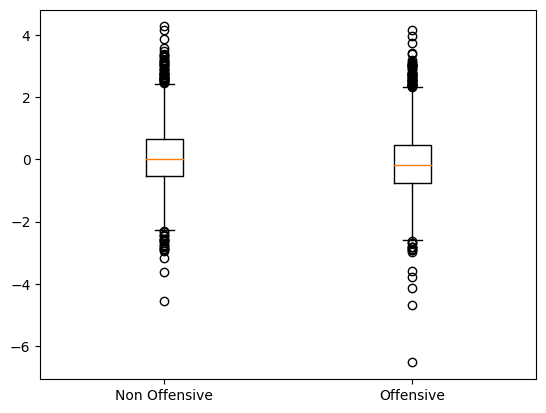

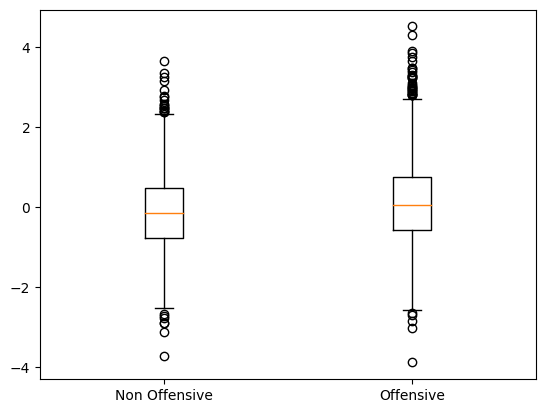

Minimum entity-sentiment score under 17.56198347107438
22.65840220385675


/tmp/ipykernel_33/682535898.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Minimum entity-sentiment score under", len(df_non_offensive.dropna()[df_non_offensive["minimum_sentiment_score"] < 0]) / len(df_non_offensive) * 100)
/tmp/ipykernel_33/682535898.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(df_offensive.dropna()[df_offensive["minimum_sentiment_score"] < 0]) / len(df_offensive) * 100)


In [2]:
df = pd.read_csv("cleaned_data_entropy_surprisal_sentiment.csv")

df_non_offensive = df[df["joke_type"] == 0]
df_offensive = df[df["joke_type"] == 1]

# Compute average difference for offensive and non-offensive jokes
print("Non-offensive jokes:")
print("Entropy mean: ", df_non_offensive["entropy"].mean())
print("Surprisal mean: ", df_non_offensive["surprisal"].mean())
print("\n")
print("Offensive jokes:")
print("Entropy mean: ", df_offensive["entropy"].mean())
print("Surprisal mean: ", df_offensive["surprisal"].mean())

fig, ax = plt.subplots()
ax.boxplot([df_non_offensive["surprisal"], df_offensive["surprisal"]], labels=["Non Offensive", "Offensive"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([df_non_offensive["entropy"], df_offensive["entropy"]], labels=["Non Offensive", "Offensive"])
plt.show()

print("Minimum entity-sentiment score under", len(df_non_offensive.dropna()[df_non_offensive["minimum_sentiment_score"] < 0]) / len(df_non_offensive) * 100)
print(len(df_offensive.dropna()[df_offensive["minimum_sentiment_score"] < 0]) / len(df_offensive) * 100)


## Create model

In [3]:
!pip install protobuf==3.20.*

In [8]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

class HumorDataset(Dataset):
    def __init__(self, texts, features, labels, tokenizer, max_len):
        self.texts = texts
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        if len(self.features) > 0: features = self.features[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'features': (torch.tensor(features, dtype=torch.float) if len(self.features) > 0 else torch.tensor([])),
            'labels': torch.tensor(int(label), dtype=torch.long)
        }

class HumorClassifier(nn.Module):
    def __init__(self, n_features):
        super(HumorClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size + n_features, 2)
        

    def forward(self, input_ids, attention_mask, features):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        if len(features) > 0: output = torch.cat((output, features), 1)
        return self.out(output)

def create_data_loader(df, tokenizer, max_len, batch_size, custom_features):
    ds = HumorDataset(
        texts=(df["title"] + "[SEP]" + df["selftext"]).to_numpy(),
        features=df[custom_features].to_numpy(),
        labels=df.joke_type.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=4)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        features = d["features"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            features=features
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            features = d['features'].to(device)
            labels = d['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                features=features
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def create_model(features, n_features, df_train, df_val, df_test):

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = HumorClassifier(n_features=n_features)

    BATCH_SIZE = 16
    MAX_LEN = 128

    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, features)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE, features)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)
    loss_fn = nn.CrossEntropyLoss().to(device)

    EPOCHS = 4
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
    
    return model, val_acc

In [5]:
df = pd.read_csv("cleaned_data_entropy_surprisal_sentiment.csv")
df["minimum_sentiment_score"] = df["minimum_sentiment_score"].fillna(0)
df_train, df_test = train_test_split(df, test_size=0.2)
df_train, df_val = train_test_split(df_train, test_size=0.1)

In [9]:
model_1, val_acc_1 = create_model([], 0, df_train, df_val, df_test)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.37555192831818385 accuracy 0.8349677110739058
Val   loss 0.21636365670710803 accuracy 0.9204301075268817
Epoch 2/4
----------
Train loss 0.14024646329082094 accuracy 0.9564697440803636
Val   loss 0.34658076557097955 accuracy 0.9139784946236559
Epoch 3/4
----------
Train loss 0.05107294292547313 accuracy 0.9878019612532888
Val   loss 0.39498435814166444 accuracy 0.9161290322580645
Epoch 4/4
----------
Train loss 0.02765483962350173 accuracy 0.9949772781631189
Val   loss 0.43941965619354356 accuracy 0.9161290322580645


In [10]:
model_2, val_acc_2 = create_model(['surprisal'], 1, df_train, df_val, df_test)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.3788767353851945 accuracy 0.8433389141353743
Val   loss 0.24821302214016516 accuracy 0.896774193548387
Epoch 2/4
----------
Train loss 0.15360645872304388 accuracy 0.9562305668500359
Val   loss 0.38751436802558603 accuracy 0.9010752688172043
Epoch 3/4
----------
Train loss 0.051204880580878354 accuracy 0.9880411384836164
Val   loss 0.3803339557314757 accuracy 0.9139784946236559
Epoch 4/4
----------
Train loss 0.020219324384696022 accuracy 0.9961731643147573
Val   loss 0.46142924038382865 accuracy 0.9247311827956989


In [11]:
model_3, val_acc_3 = create_model(['entropy'], 1, df_train, df_val, df_test)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.38753932442885775 accuracy 0.8342501793829228
Val   loss 0.24426733180880547 accuracy 0.896774193548387
Epoch 2/4
----------
Train loss 0.1705334932989448 accuracy 0.9478593637885674
Val   loss 0.36681993200521296 accuracy 0.9032258064516129
Epoch 3/4
----------
Train loss 0.06650029509310533 accuracy 0.9830184166467353
Val   loss 0.443762677993315 accuracy 0.8989247311827957
Epoch 4/4
----------
Train loss 0.035372368625022174 accuracy 0.9909112652475485
Val   loss 0.4872849535565668 accuracy 0.9075268817204301


In [12]:
model_4, val_acc_4 = create_model(['entropy', 'surprisal'], 2, df_train, df_val, df_test)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.3881328716476 accuracy 0.8306625209280077
Val   loss 0.2194051008671522 accuracy 0.9053763440860215
Epoch 2/4
----------
Train loss 0.1480330709294231 accuracy 0.9507294905524994
Val   loss 0.357181936269626 accuracy 0.896774193548387
Epoch 3/4
----------
Train loss 0.06393818385860854 accuracy 0.9851710117196844
Val   loss 0.4465288499758268 accuracy 0.9053763440860215
Epoch 4/4
----------
Train loss 0.03648597925431753 accuracy 0.9923463286295146
Val   loss 0.3810534897764834 accuracy 0.9204301075268817


In [14]:
model_5, val_acc_5 = create_model(['entropy', 'surprisal', 'minimum_sentiment_score'], 3, df_train, df_val, df_test)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.3881083659202088 accuracy 0.8282707486247309
Val   loss 0.22640849935511748 accuracy 0.9118279569892473
Epoch 2/4
----------
Train loss 0.14042933425201345 accuracy 0.9564697440803636
Val   loss 0.40244456853639954 accuracy 0.9010752688172043
Epoch 3/4
----------
Train loss 0.051068198307615505 accuracy 0.9870844295623057
Val   loss 0.44585992565844207 accuracy 0.9075268817204301
Epoch 4/4
----------
Train loss 0.023640954980865752 accuracy 0.995694809854102
Val   loss 0.5526188871862057 accuracy 0.8989247311827957


In [20]:
models = []
models.append((model_1, val_acc_1, []))
models.append((model_2, val_acc_2, ['surprisal']))
models.append((model_3, val_acc_3, ['entropy']))
models.append((model_4, val_acc_4, ['entropy', 'surprisal']))
models.append((model_5, val_acc_5, ['entropy', 'surprisal', 'minimum_sentiment_score']))

models.sort(key=lambda x: x[1], reverse=True)

print("Testing accuracy with best model:")
model, val_acc, features = models[0]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_data_loader = create_data_loader(df_test, tokenizer, 128, 16, features)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
print(test_acc)

Testing accuracy with best model:
tensor(0.9002, device='cuda:0', dtype=torch.float64)


In [ ]:

    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, features)
    test_acc, _ = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )

    print(f'Test accuracy {test_acc}')